# BayesNet

A `BayesNet` in GTSAM represents a directed graphical model, specifically the result of running sequential variable elimination (like Cholesky or QR factorization) on a `FactorGraph`.

It is essentially a collection of `Conditional` objects, ordered according to the elimination order. Each conditional represents $P(	ext{variable} | 	ext{parents})$, where the parents are variables that appear later in the elimination ordering.

A Bayes net represents the joint probability distribution as a product of conditional probabilities stored in the net:

$$
P(X_1, X_2, \dots, X_N) = \prod_{i=1}^N P(X_i | \text{Parents}(X_i))
$$
The total log-probability of an assignment is the sum of the log-probabilities of its conditionals:
$$
\log P(X_1, \dots, X_N) = \sum_{i=1}^N \log P(X_i | \text{Parents}(X_i))
$$

Like `FactorGraph`, `BayesNet` is templated on the type of conditional it stores (e.g., `GaussianBayesNet`, `DiscreteBayesNet`).

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/inference/doc/BayesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install gtsam

In [1]:
import gtsam
import numpy as np

# We need concrete graph types and elimination to get a BayesNet
from gtsam import GaussianFactorGraph, Ordering, GaussianBayesNet
from gtsam import symbol_shorthand

X = symbol_shorthand.X
L = symbol_shorthand.L

## Creating a BayesNet (via Elimination)

BayesNets are typically obtained by eliminating a `FactorGraph`.

In [2]:
# Create a simple Gaussian Factor Graph P(x0) P(x1|x0) P(x2|x1)
graph = GaussianFactorGraph()
model = gtsam.noiseModel.Isotropic.Sigma(1, 1.0)
graph.add(X(0), -np.eye(1), np.zeros(1), model)
graph.add(X(0), -np.eye(1), X(1), np.eye(1), np.zeros(1), model)
graph.add(X(1), -np.eye(1), X(2), np.eye(1), np.zeros(1), model)
print("Original Factor Graph:")
graph.print()

# Eliminate sequentially using a specific ordering
ordering = Ordering([X(0), X(1), X(2)])
bayes_net = graph.eliminateSequential(ordering)

print("\nResulting BayesNet:")
bayes_net.print()

Original Factor Graph:

size: 3
factor 0: 
  A[x0] = [
	-1
]
  b = [ 0 ]
  Noise model: unit (1) 
factor 1: 
  A[x0] = [
	-1
]
  A[x1] = [
	1
]
  b = [ 0 ]
  Noise model: unit (1) 
factor 2: 
  A[x1] = [
	-1
]
  A[x2] = [
	1
]
  b = [ 0 ]
  Noise model: unit (1) 

Resulting BayesNet:

size: 3
conditional 0:  p(x0 | x1)
  R = [ 1.41421 ]
  S[x1] = [ -0.707107 ]
  d = [ 0 ]
  logNormalizationConstant: -0.572365
  No noise model
conditional 1:  p(x1 | x2)
  R = [ 1.22474 ]
  S[x2] = [ -0.816497 ]
  d = [ 0 ]
  logNormalizationConstant: -0.716206
  No noise model
conditional 2:  p(x2)
  R = [ 0.57735 ]
  d = [ 0 ]
  mean: 1 elements
  x2: 0
  logNormalizationConstant: -1.46824
  No noise model


## Properties and Access

A `BayesNet` provides access to its constituent conditionals and basic properties.

In [3]:
print(f"BayesNet size: {bayes_net.size()}")

# Access conditional by index
conditional1 = bayes_net.at(1)
print("Conditional at index 1: ")
conditional1.print()

# Get all keys involved
bn_keys = bayes_net.keys()
print(f"Keys in BayesNet: {bn_keys}")

BayesNet size: 3
Conditional at index 1: 
GaussianConditional p(x1 | x2)
  R = [ 1.22474 ]
  S[x2] = [ -0.816497 ]
  d = [ 0 ]
  logNormalizationConstant: -0.716206
  No noise model
Keys in BayesNet: x0x1x2


## Evaluation and Solution

The `logProbability(Values)` method computes the log probability of a variable assignment given the conditional distributions in the Bayes net. For Gaussian Bayes nets, the `optimize()` method can be used to find the maximum likelihood estimate (MLE) solution via back-substitution.

In [4]:
# For GaussianBayesNet, we use VectorValues
mle_solution = bayes_net.optimize()

# Calculate log probability (requires providing values for all variables)
log_prob = bayes_net.logProbability(mle_solution)
print(f"Log Probability at {mle_solution.at(X(0))[0]:.0f},{mle_solution.at(X(1))[0]:.0f},{mle_solution.at(X(2))[0]:.0f}]: {log_prob}")

print("Optimized Solution (MLE):")
mle_solution.print()

Log Probability at 0,0,0]: -2.7568155996140185
Optimized Solution (MLE):
VectorValues: 3 elements
  x0: 0
  x1: 0
  x2: 0


## Visualization

Bayes nets can also be visualized using Graphviz.

digraph {
  size="5,5";

  var8646911284551352320[label="x0"];
  var8646911284551352321[label="x1"];
  var8646911284551352322[label="x2"];

  var8646911284551352322->var8646911284551352321
  var8646911284551352321->var8646911284551352320
}


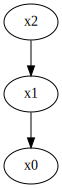

In [5]:
dot_string = bayes_net.dot()
print(dot_string)

# To render:
# dot -Tpng bayesnet.dot -o bayesnet.png
import graphviz
graphviz.Source(dot_string)